## Python library for Fixed Income Portfolio Management

In [2]:
from datetime import datetime
import pandas as pd
import copy

from bond import Bond
from portfolio import Portfolio
from yield_curve import YieldCurve
from swap import Swap
from strategies import *
from utilities import *
from portfolio_management import process_time_step
%reload_ext autoreload
%autoreload 2 

In [3]:

# Load the Excel file
file_path = 'Fixed Income Portfolio 2024 - Copy.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the data from the initial sheet "August 14 2024"
portfolio_data = excel_data.parse("August 14 2024")
portfolio_data.dropna()

# Display the first few rows of the loaded data for inspection
portfolio_data.head()

,CUSIP,BBG,NAME,COUNTRY,INDUSTRY_SECTOR,Type,INDUSTRY_GROUP,CURRENCY,TICKER,CALLABLE,...,RISK,STOCHASTIC_OAS_BID_CNVX,DAYS_TO_NEXT_COUPON,NXT_CPN_DT,PREV_CPN_DT,PAYMENT_RANK,RTG_SP,RTG_MOODY,RTG_FITCH,BB_COMPOSITE
0,515110BN3,515110BN3 govt,LANDWIRTSCH. RENTENBANK,GE,Financial,Financial,Banks,USD,RENTEN,N,...,0.398568,0.003245,151,2025-01-13,2024-07-13,Sr Unsecured,AAA,Aaa,AAA,AAA
1,4581X0CM8,4581X0CM8 govt,INTER-AMERICAN DEVEL BK,SNAT,Government,Government,Multi-National,USD,IADB,N,...,0.404001,0.003331,153,2025-01-15,2024-07-15,Sr Unsecured,AAA,Aaa,AAA,AAA
2,045167CW1,045167CW1 govt,ASIAN DEVELOPMENT BANK,SNAT,Government,Government,Multi-National,USD,ASIA,N,...,0.421789,0.003643,160,2025-01-22,2024-07-22,Sr Unsecured,AAA,Aaa,AAA,AAA
3,XS2106583359,XS2106583359 corp,MHC AMERICA HOLDINGS,US,Financial,Corporate,Diversified Finan Serv,USD,MITHCC,N,...,NaN,NaN,69,2024-10-24,2024-07-24,Sr Unsecured,NaN,NaN,NaN,NaN
4,298785GS9,298785GS9 govt,EUROPEAN INVESTMENT BANK,SNAT,Government,Government,Multi-National,USD,EIB,N,...,0.467964,0.004507,179,2025-02-10,2024-08-10,Sr Unsecured,AAA,Aaa,AAA,AAA


### Initial portfolio

In [4]:
# Initialize portfolio
initial_portfolio = Portfolio(initial_investment=500_000_000)
Bond.load_bond_data(("Fixed Income Portfolio 2024 - Copy.xlsx"))

selected_cusips = [
    "668027at2",
    "156700at3",
    "984245aq3",
    "984121CB7",
    "71654QCM2",
    "912810RQ3",
    "912810SU3",
    "912810SP4",
    "515110BN3",
    "4581X0CM8",
    "045167CW1",
]

current_date = "2024-08-14"

# Create and add Bond objects to the portfolio for each selected CUSIP
for cusip in selected_cusips:
    bond = Bond.create_bond_from_cusip(cusip, current_date, initial_date="2024-08-14", settlement_date="2024-08-14")
    initial_portfolio.add_bond(bond, current_date)

# Define custom allocation details
custom_allocation = {
    "High Risk / High Yield": {"allocation": 0.30, "cusips": ["668027at2", "156700at3", "984245aq3", "984121CB7", "71654QCM2"]},
    "Treasury Bonds": {"allocation": 0.40, "cusips": ["912810SU3", "912810SP4", "912810RQ3"]},
    "Triple-Rated Bonds": {"allocation": 0.30, "cusips": ["515110BN3", "4581X0CM8", "045167CW1"]}
}

initial_portfolio.allocate_investment(custom_allocation, 500_000_000*2/3, current_date)
initial_portfolio.print_portfolio_info()
initial_portfolio.print_portfolio_df()
initial_portfolio.export_portfolio_to_excel('portfolio.xlsx')

PORTFOLIO SUMMARY
Initial Investment: $500,000,000.00
Currently Invested: $333,333,333.33
Cash Balance: $166,666,666.67
Market Value: $333,333,333.33
Mark-to-Market: $333,333,333.33
Accrual Interest: $0.00
Unrealized P&L: $333,333,333.33
Realized P&L: $-333,333,333.33
Growth: 66.67%
Portfolio Yield: 3.22%
Portfolio Yield (Weighted): 3.56%
Macaulay Duration: 8.85
Modified Duration: 8.57
Modified Duration (Weighted): 9.68
Dollar Duration: $28,581,576.85
DV01: $285,815.77
Convexity: 1.65
Approximate DV01: $285,815.98
Approximate Convexity: 1.63
Number of Bonds: 11
Number of Swaps: 0
Total Duration: 8.57
Total DV01: $285,815.77
Total Market Value: $500,000,000.00


,CUSIP,Bond Name,Country,Industry Sector,Industry Group,Rating,Coupon (%),Maturity,Frequency,Notional ($),...,Dollar Duration ($),DV01,Convexity,Approximate DV01,Approximate Convexity,Daily Accrual ($),Dirty Price ($),MTM ($),PL ($),LAST_PX 2024-08-14
0,668027at2,NORTHWESTERN BELL TELEPH,US,Communications,Telecommunications,CCC+,0.07750,2030-05-01,2,2.000000e+07,...,8.748299e+05,8748.299484,0.250481,8748.300074,0.255666,4305.555556,51.306500,2.000000e+07,2.000000e+07,51.306500
1,156700at3,LUMEN TECHNOLOGIES INC,US,Communications,Telecommunications,CC+,0.07650,2042-03-15,2,2.000000e+07,...,1.845039e+06,18450.386754,1.375238,18450.393571,1.268168,4250.000000,45.339000,2.000000e+07,2.000000e+07,45.339000
2,984245aq3,YPF SOCIEDAD ANONIMA,AR,Energy,Oil&Gas,CCC-,0.06950,2027-07-21,2,2.000000e+07,...,5.052546e+05,5052.545511,0.076863,5052.545648,0.090634,3861.111111,92.881000,2.000000e+07,2.000000e+07,92.881000
3,984121CB7,XEROX CORPORATION,US,Technology,Office/Business Equip,B+,0.06750,2039-12-15,2,2.000000e+07,...,1.830071e+06,18300.712311,1.249943,18300.718120,1.176391,3750.000000,77.168000,2.000000e+07,2.000000e+07,77.168000
4,71654QCM2,PETROLEOS MEXICANOS,MX,Energy,Oil&Gas,BB-,0.06500,2029-01-23,2,2.000000e+07,...,7.368323e+05,7368.322625,0.166332,7368.322983,0.180892,3611.111111,92.347000,2.000000e+07,2.000000e+07,92.347000
5,912810RQ3,US TREASURY N/B,US,Government,Sovereign,NR,0.02500,2046-02-15,2,4.444444e+07,...,7.267108e+06,72671.084037,3.285121,72671.137376,3.285381,3086.419753,75.195312,4.444444e+07,4.444444e+07,75.195312
6,912810SU3,US TREASURY N/B,US,Government,Sovereign,NR,0.01875,2051-02-15,2,4.444444e+07,...,9.163115e+06,91631.151826,5.110114,91631.253714,5.125909,2314.814815,62.664062,4.444444e+07,4.444444e+07,62.664062
7,912810SP4,US TREASURY N/B,US,Government,Sovereign,NR,0.01375,2050-08-15,2,4.444444e+07,...,9.622668e+06,96226.684500,5.369431,96226.792363,5.434864,1697.530864,55.046875,4.444444e+07,4.444444e+07,55.046875
8,515110BN3,LANDWIRTSCH. RENTENBANK,GE,Financial,Banks,AAA,0.02000,2025-01-13,2,3.333333e+07,...,1.352422e+05,1352.422465,0.001713,1352.422472,0.005640,1851.851852,98.776000,3.333333e+07,3.333333e+07,98.776000
9,4581X0CM8,INTER-AMERICAN DEVEL BK,SNAT,Government,Multi-National,AAA,0.02125,2025-01-15,2,3.333333e+07,...,1.368880e+05,1368.879817,0.001759,1368.879824,0.005727,1967.592593,98.813000,3.333333e+07,3.333333e+07,98.813000


Portfolio data exported successfully to portfolio.xlsx


In [ ]:
initial_portfolio.plot_country_distribution()
initial_portfolio.plot_industry_sector_distribution()
initial_portfolio.plot_industry_group_distribution()
initial_portfolio.plot_risk_distribution()
initial_portfolio.plot_duration_distribution()
initial_portfolio.plot_maturity_distribution()
initial_portfolio.plot_long_short_yield_duration()

### Yield Curve

In [10]:
# Paths to the yield curve data files for the years 2020 to 2024
files = [
    "daily-treasury-rates-2020.csv",
    "daily-treasury-rates-2021.csv",
    "daily-treasury-rates-2022.csv",
    "daily-treasury-rates-2023.csv",
    "daily-treasury-rates-2024.csv"
]

# Initialize and load the yield curve with multiple files
yield_curve = YieldCurve()
yield_curve.load_multiple_files(files)
yield_curve.load_nss_parameters("feds200628.csv")

### Find treasuries in excel file for different maturities

In [499]:
file_path = 'Fixed Income Portfolio 2024 - Copy.xlsx'

# Define target years from reference date
target_years_to_check = [1, 3, 5, 20]
cusip_maturity_dict = {}

bond_results = filter_bonds_from_excel(file_path, "August 14 2024", target_years_to_check, only_government=True, only_us=True)

# Display results
for maturity, cusips in bond_results.items():
    cusip_maturity_dict[maturity] = cusips
    print(f"Maturity {maturity}:")
    print(cusips)
    print()


Maturity 2025-08-14:
['912828J27', '912828XB1', '912828K74', '912810EW4', '3135G0K36', '912828R36']

Maturity 2027-08-14:
['912810EX2', '3135G0Q22', '912810EY0', '912810EZ7', '91282CAD3', '912810FA1', '912810FB9', '91282CCH2']

Maturity 2029-08-13:
['912810FE3', '912810FF0', '912810FG8', '31359MEU3', '912810FJ2', '3134A3U46', '31359MFJ7', '761157AB2', '31359MFP3', '912810FM5', '912828ZQ6']

Maturity 2044-08-09:
['912810RC4', '912810RD2', '912810RE0', '912810RG5', '912810RH3', '912810RJ9', '912810RK6', '912810RM2']



In [ ]:
one_year_maturity = cusip_maturity_dict["2025-08-14"]
three_year_maturity = cusip_maturity_dict["2027-08-14"]
five_year_maturity = cusip_maturity_dict["2029-08-13"]
twenty_year_maturity = cusip_maturity_dict["2044-08-09"]

## Portfolio Evolution

### 2024 September 8 - Long Only

In [439]:
# Initialize portfolio
portfolio_september_08 = copy.deepcopy(initial_portfolio)
prev_date = "2024-08-14"
return_history = {}

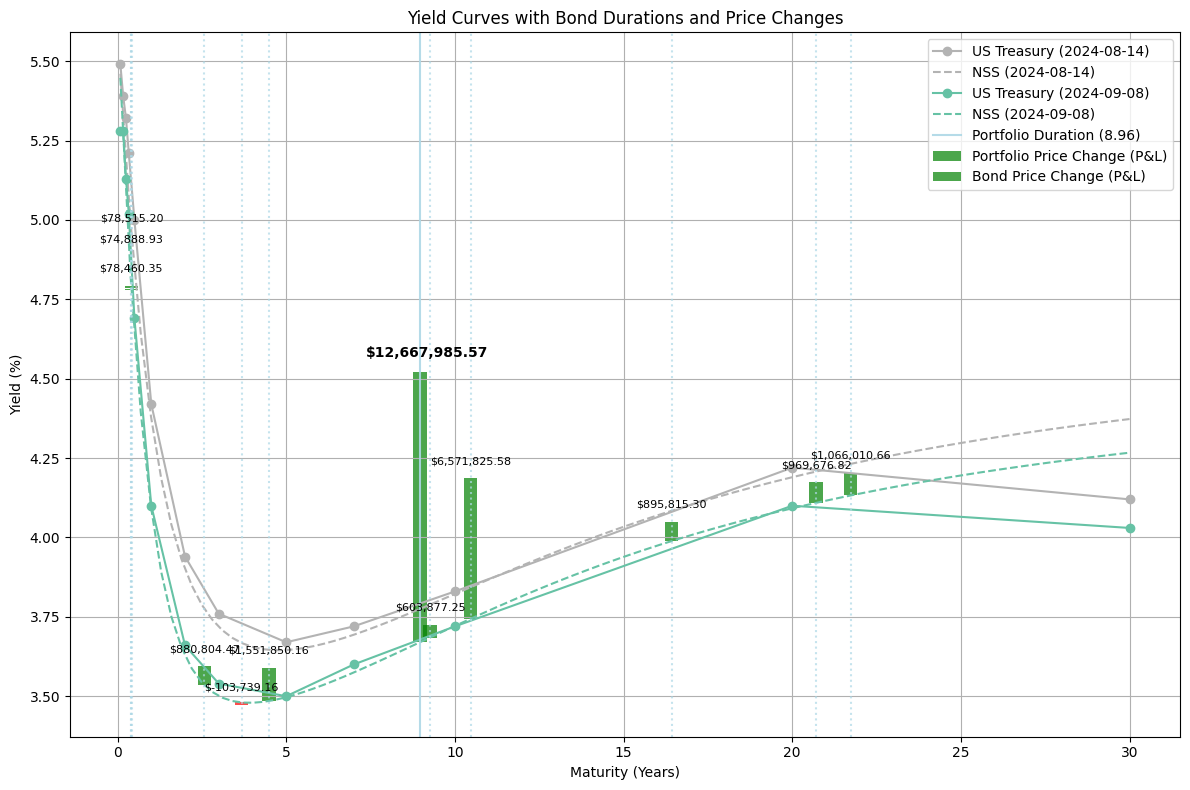

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $333,333,333.33    $346,001,318.90    $ 12,667,985.57
Cash Balance:           $166,666,666.67    $166,666,666.67    $          0.00
Total Value:            $500,000,000.00    $512,667,985.57    $ 12,667,985.57
Return:                                 2.53%
Mark-to-Market:                         $12,667,985.57
Accrual Interest:                       $781,148.15
Unrealized P&L:                         $13,449,133.72
Realized P&L:                           $0.00
Strategy Gain/Cost:                     $0.00
Duration:                               8.96
DV01:                                   $310,081.35
Yield Curve Shift:                      -18.77%
Yield Change at Duration:               -10.50%
Yield Impact:                           $3,255,990.84
Convexity Impact:                       $3,313,172.62
Predicted Price Change:                 $6,5

In [440]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[3]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[2], "%B %d %Y")

# Process time step
metrics, portfolio_september_08, staged_date = process_time_step(
    portfolio=portfolio_september_08,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
)

### 2024 September 15 - Rebalance to Shorter Duration

In [441]:
portfolio_september_15 = copy.deepcopy(portfolio_september_08)

Rebalancing portfolio: Current duration is 8.96, Target duration is 3.00
Decreasing portfolio duration...
Reduced weight of bond 912810SP4 from 44444444.44 to 8888888.89
Reduced weight of bond 912810SU3 from 44444444.44 to 8888888.89
Reduced weight of bond 912810RQ3 from 44444444.44 to 8888888.89
Reduced weight of bond 156700at3 from 20000000.00 to 4000000.00
Reduced weight of bond 984121CB7 from 20000000.00 to 4000000.00
Reduced weight of bond 668027at2 from 20000000.00 to 4000000.00
Reduced weight of bond 71654QCM2 from 20000000.00 to 4000000.00
Increased weight of bond 515110BN3 from 53333333.33 to 60000000.00
Increased weight of bond 4581X0CM8 from 86666666.67 to 60000000.00
Increased weight of bond 045167CW1 from 120000000.00 to 60000000.00
Increased weight of bond 984245aq3 from 140000000.00 to 36000000.00
Rebalanced portfolio duration from 8.96 to 2.96 to fit target duration of 3.00


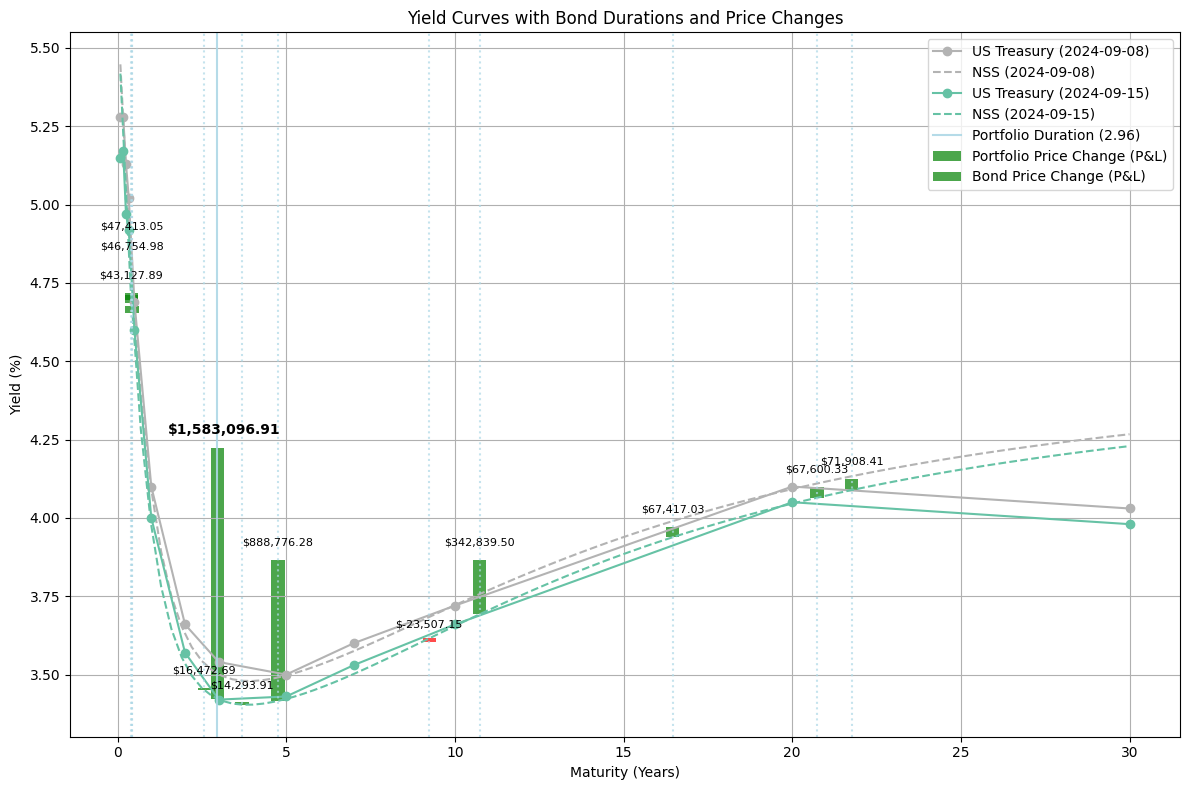

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $346,001,318.90    $264,563,631.02    $-81,437,687.88
Cash Balance:           $166,666,666.67    $249,687,451.45    $ 83,020,784.79
Total Value:            $512,667,985.57    $514,251,082.48    $  1,583,096.91
Return:                                 0.31%
Mark-to-Market:                         $1,583,096.91
Accrual Interest:                       $-628,818.21
Unrealized P&L:                         $954,278.70
Realized P&L:                           $83,020,784.79
Strategy Gain/Cost:                     $83,020,784.79
Duration:                               2.96
DV01:                                   $78,238.74
Yield Curve Shift:                      -9.23%
Yield Change at Duration:               -8.07%
Yield Impact:                           $631,223.10
Convexity Impact:                       $402,393.12
Predicted Price Change:             

In [442]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[4]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[3], "%B %d %Y")

# Process time step
metrics, portfolio_september_15, staged_date = process_time_step(
    portfolio=portfolio_september_15,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=rebalance_portfolio_strategy,
    strategy_args={"target_duration": 3.0, "scale_factor": 0.8},
)

### 2024 September 22 - Hedging using Treasuries

In [443]:
portfolio_september_22 = copy.deepcopy(portfolio_september_15)

Hedged portfolio duration risk by shorting 50957505.92 number of Treasury bond 912810RP5.


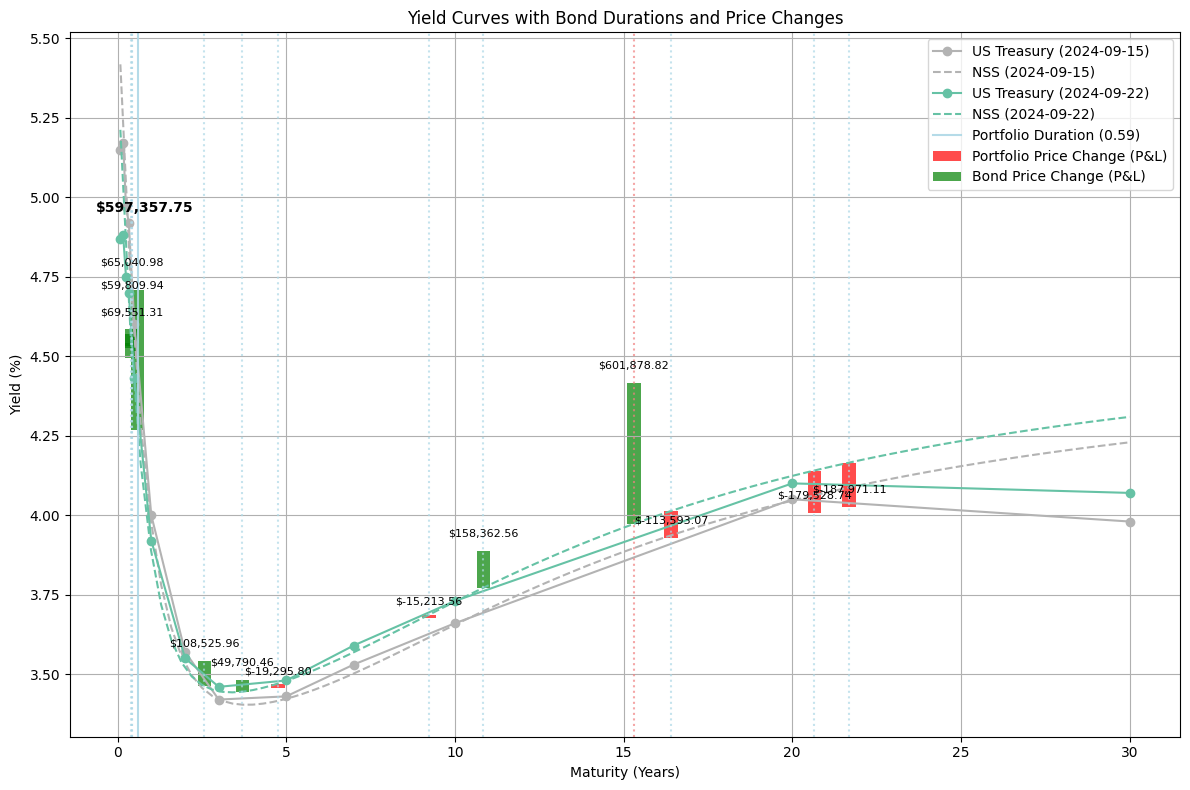

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $264,563,631.02    $214,203,482.85    $-50,360,148.17
Cash Balance:           $249,687,451.45    $300,644,957.38    $ 50,957,505.92
Total Value:            $514,251,082.48    $514,848,440.23    $    597,357.75
Return:                                 0.12%
Mark-to-Market:                         $597,357.75
Accrual Interest:                       $-29,725.21
Unrealized P&L:                         $567,632.54
Realized P&L:                           $50,957,505.92
Strategy Gain/Cost:                     $50,957,505.92
Duration:                               0.59
DV01:                                   $12,737.35
Yield Curve Shift:                      -7.08%
Yield Change at Duration:               -13.68%
Yield Impact:                           $174,305.61
Convexity Impact:                       $1,654.94
Predicted Price Change:                 

In [444]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[5]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[4], "%B %d %Y")

# Process time step
metrics, portfolio_september_22, staged_date = process_time_step(
    portfolio=portfolio_september_22,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=hedging_strategy,
    strategy_args={"target_duration": 0,
                   "treasury_cusip": "912810RP5",
                    "initial_date": "2024-08-14"}
)

### 2024 September 29 - Positive Butterfly Strategy

In [445]:
portfolio_september_29 = copy.deepcopy(portfolio_september_22)
# portfolio_september_29.sell_all(current_date)
# portfolio_september_29.remove_bond("912810RP5", current_date)

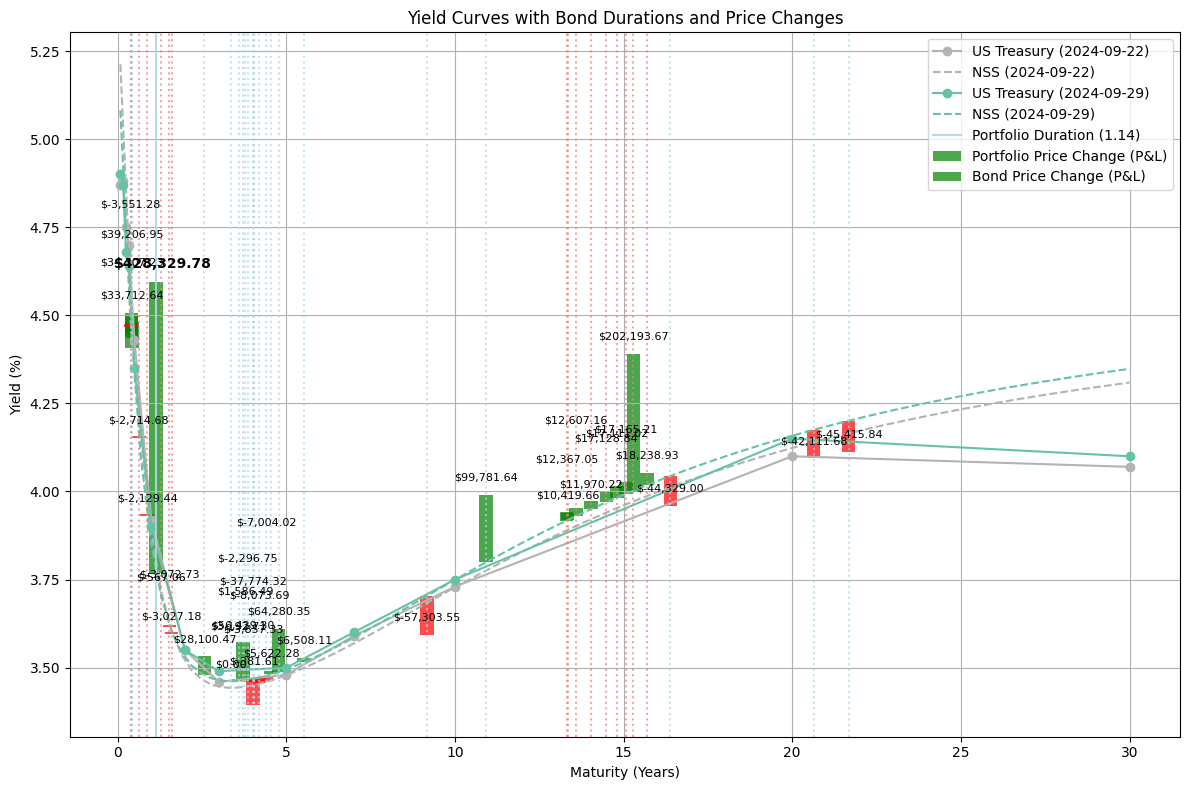

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $214,203,482.85    $274,631,812.63    $ 60,428,329.78
Cash Balance:           $300,644,957.38    $240,644,957.38    $-60,000,000.00
Total Value:            $514,848,440.23    $515,276,770.01    $    428,329.78
Return:                                 0.08%
Mark-to-Market:                         $428,329.78
Accrual Interest:                       $102,982.95
Unrealized P&L:                         $531,312.73
Realized P&L:                           $-60,000,000.00
Strategy Gain/Cost:                     $-60,000,000.00
Duration:                               1.14
DV01:                                   $31,436.00
Yield Curve Shift:                      -0.38%
Yield Change at Duration:               -2.33%
Yield Impact:                           $73,116.87
Convexity Impact:                       $2,975.40
Predicted Price Change:                 

In [446]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[6]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[5], "%B %d %Y")

# Process time step
metrics, portfolio_september_29, staged_date = process_time_step(
    portfolio=portfolio_september_29,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=butterfly_strategy,
    strategy_args={
        "wing_bonds": one_year_maturity + twenty_year_maturity,     # Short and long-duration bonds
        "body_bonds": five_year_maturity,                           # Medium-duration bond
        "wing_weight": 0.3,
        "body_weight": 0.6,
        "investment": 300_000_000*2/3,
        "initial_date": "2024-08-14",
        "positive_butterfly": True,
    },
)

### 2024 October 7 - Flattener Strategy

In [455]:
portfolio_october_07 = copy.deepcopy(portfolio_september_29)

Executing Flattener Strategy (Target Duration ≥ 5.00 years)
Flattener Strategy executed. Total Strategy Cost: $-208,711,929.19


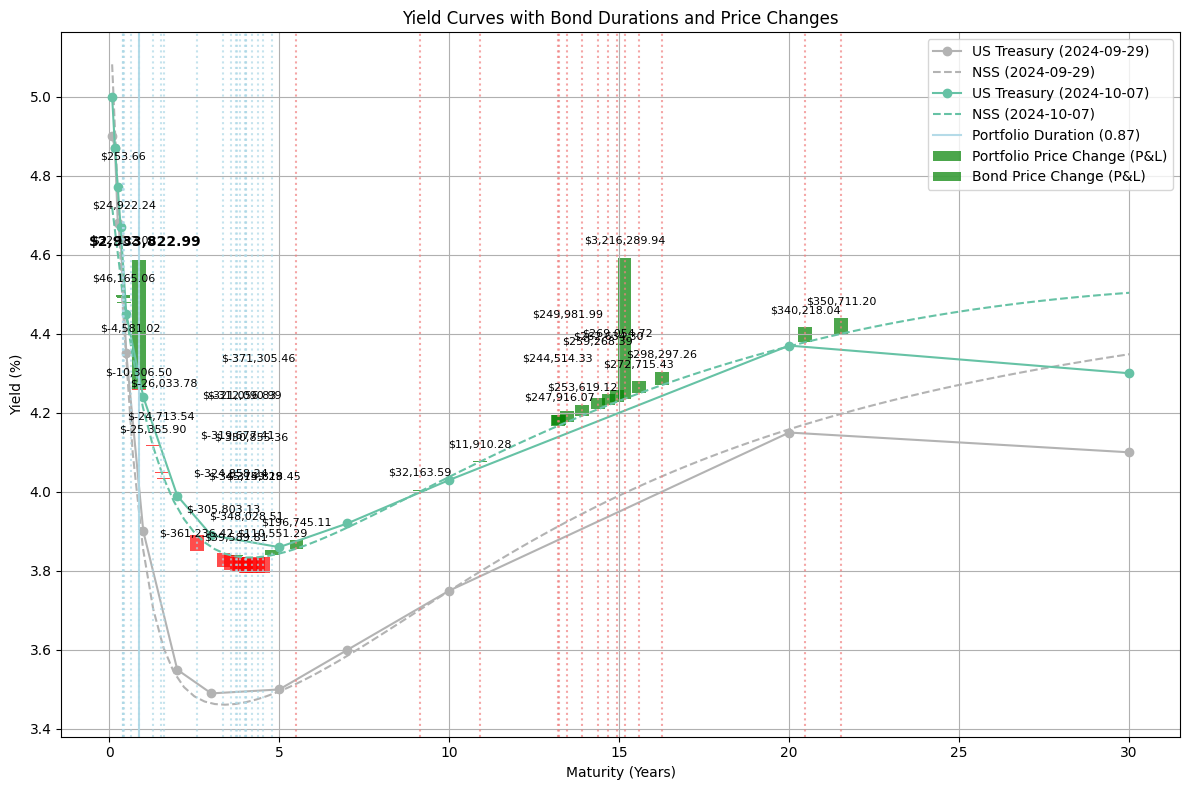

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $274,631,812.63    $486,277,564.82    $211,645,752.19
Cash Balance:           $240,644,957.38    $ 31,933,028.18    $-208,711,929.19
Total Value:            $515,276,770.01    $518,210,593.00    $  2,933,822.99
Return:                                 0.57%
Mark-to-Market:                         $2,933,822.99
Accrual Interest:                       $258,378.92
Unrealized P&L:                         $3,192,201.91
Realized P&L:                           $-208,711,929.19
Strategy Gain/Cost:                     $-208,711,929.19
Duration:                               0.87
DV01:                                   $42,242.18
Yield Curve Shift:                      22.15%
Yield Change at Duration:               31.99%
Yield Impact:                           $-1,351,218.40
Convexity Impact:                       $644,069.03
Predicted Price Change:    

In [456]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[7]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[6], "%B %d %Y")

metrics, portfolio_october_07, staged_date = process_time_step(
    portfolio=portfolio_october_07,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=flattener_strategy,
    strategy_args={
        "target_long_duration": 5.0,  # Bonds with duration > 10 years
        "short_long_bonds": True,
    },
)

### 2024 October 12 - Positive Butterfly Strategy

In [457]:
portfolio_october_12 = copy.deepcopy(portfolio_october_07)
portfolio_october_12.sell_all(current_date)
portfolio_october_12.print_portfolio_info()

Sold all bonds in the portfolio. Total proceeds: $486,277,564.82
Invalid cash flows or market value for portfolio.
Invalid total weight for portfolio duration. Returning 0.
PORTFOLIO SUMMARY
Initial Investment: $500,000,000.00
Currently Invested: $0.00
Cash Balance: $518,210,593.00
Market Value: $0.00
Mark-to-Market: $0.00
Accrual Interest: $0.00
Unrealized P&L: $0.00
Realized P&L: $18,210,593.00
Growth: 0.00%
Portfolio Yield: 0.00%
Portfolio Yield (Weighted): 0.00%
Macaulay Duration: 0.00
Modified Duration: 0.00
Modified Duration (Weighted): 0.00
Dollar Duration: $0.00
DV01: $0.00
Convexity: 0.00
Approximate DV01: $0.00
Approximate Convexity: 0.00
Number of Bonds: 0
Number of Swaps: 0
Total Duration: 0.00
Total DV01: $0.00
Total Market Value: $518,210,593.00


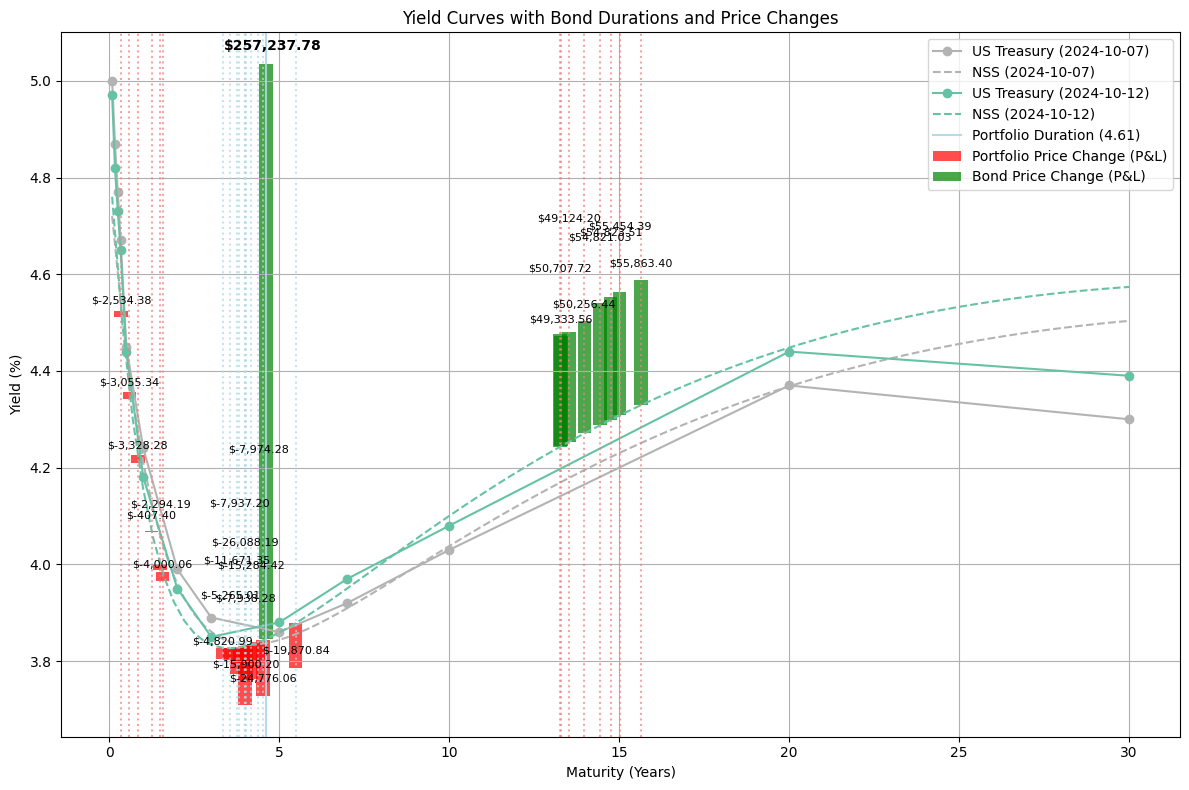

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $          0.00    $ 60,257,237.78    $ 60,257,237.78
Cash Balance:           $518,210,593.00    $458,210,593.00    $-60,000,000.00
Total Value:            $518,210,593.00    $518,467,830.78    $    257,237.78
Return:                                 0.05%
Mark-to-Market:                         $257,237.78
Accrual Interest:                       $73,559.25
Unrealized P&L:                         $330,797.04
Realized P&L:                           $-60,000,000.00
Strategy Gain/Cost:                     $-60,000,000.00
Duration:                               4.61
DV01:                                   $27,748.85
Yield Curve Shift:                      -0.08%
Yield Change at Duration:               0.86%
Yield Impact:                           $-23,751.43
Convexity Impact:                       $600.75
Predicted Price Change:                 $-2

In [458]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[8]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[7], "%B %d %Y")

# Process time step
metrics, portfolio_october_12, staged_date = process_time_step(
    portfolio=portfolio_october_12,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=butterfly_strategy,
    strategy_args={
        "wing_bonds": one_year_maturity + twenty_year_maturity,     # Short and long-duration bonds
        "body_bonds": five_year_maturity,                           # Medium-duration bond
        "wing_weight": 0.3,
        "body_weight": 0.6,
        "investment": 200_000_000,
        "initial_date": "2024-08-14",
        "positive_butterfly": True,
    },
)

### 2024 October 21 - Barbell Strategy

In [462]:
portfolio_october_21 = copy.deepcopy(portfolio_october_12)
portfolio_october_21.sell_all(current_date)
portfolio_october_21.print_portfolio_info()

Sold all bonds in the portfolio. Total proceeds: $60,257,237.78
Invalid cash flows or market value for portfolio.
Invalid total weight for portfolio duration. Returning 0.
PORTFOLIO SUMMARY
Initial Investment: $500,000,000.00
Currently Invested: $0.00
Cash Balance: $518,467,830.78
Market Value: $0.00
Mark-to-Market: $0.00
Accrual Interest: $0.00
Unrealized P&L: $0.00
Realized P&L: $18,467,830.78
Growth: 0.00%
Portfolio Yield: 0.00%
Portfolio Yield (Weighted): 0.00%
Macaulay Duration: 0.00
Modified Duration: 0.00
Modified Duration (Weighted): 0.00
Dollar Duration: $0.00
DV01: $0.00
Convexity: 0.00
Approximate DV01: $0.00
Approximate Convexity: 0.00
Number of Bonds: 0
Number of Swaps: 0
Total Duration: 0.00
Total DV01: $0.00
Total Market Value: $518,467,830.78


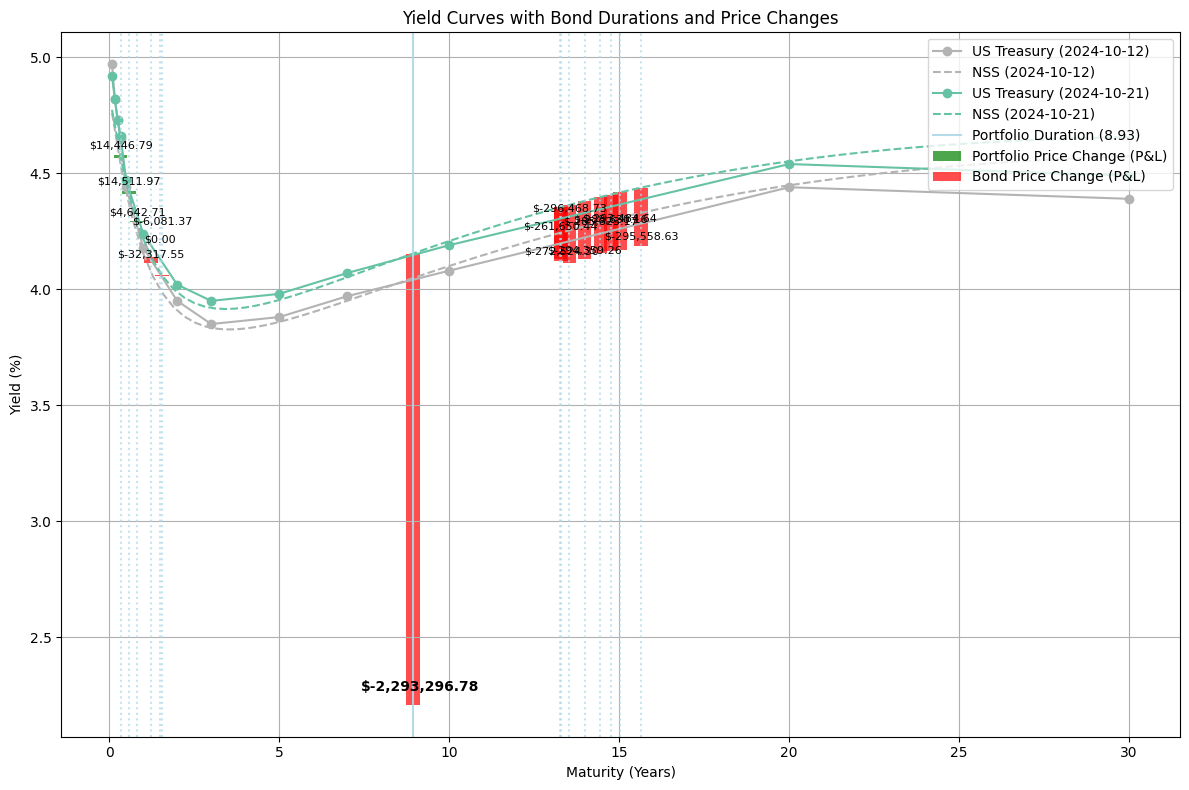

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $          0.00    $497,706,703.22    $497,706,703.22
Cash Balance:           $518,467,830.78    $ 18,467,830.78    $-500,000,000.00
Total Value:            $518,467,830.78    $516,174,534.00    $ -2,293,296.78
Return:                                 -0.44%
Mark-to-Market:                         $-2,293,296.78
Accrual Interest:                       $376,041.67
Unrealized P&L:                         $-1,917,255.12
Realized P&L:                           $-500,000,000.00
Strategy Gain/Cost:                     $-500,000,000.00
Duration:                               8.93
DV01:                                   $444,489.85
Yield Curve Shift:                      5.62%
Yield Change at Duration:               10.59%
Yield Impact:                           $-4,708,382.70
Convexity Impact:                       $4,357,049.75
Predicted Price Change

In [463]:
sheet_name = excel_data.sheet_names[9]

# Parse the current sheet
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[8], "%B %d %Y")

metrics, portfolio_october_21, staged_date = process_time_step(
    portfolio=portfolio_october_21,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=barbell_strategy,
    strategy_args={
        "short_bonds": one_year_maturity,
        "long_bonds": twenty_year_maturity,
        "short_weight": 0.4,
        "long_weight": 0.6,
        "investment": 500_000_000,
    },
)

### 2024 October 28 - Bullet Strategy

In [603]:
portfolio_october_28 = copy.deepcopy(portfolio_october_21)

Increase weight of bond 912828J27 from $33,333,333.33 to $100,000,000.00
Increase weight of bond 912828XB1 from $33,333,333.33 to $100,000,000.00
Increase weight of bond 912828K74 from $33,333,333.33 to $100,000,000.00
Sold bond 912810EW4 with duration 1.23 for $33,301,015.78
Sold bond 3135G0K36 with duration 1.48 for $33,333,333.33
Sold bond 912828R36 with duration 1.55 for $33,327,251.96
Sold bond 912810RC4 with duration 13.30 for $37,227,475.70
Sold bond 912810RD2 with duration 13.27 for $37,238,349.56
Sold bond 912810RE0 with duration 13.54 for $37,203,531.27
Sold bond 912810RG5 with duration 13.98 for $37,205,640.74
Sold bond 912810RH3 with duration 14.45 for $37,214,176.83
Sold bond 912810RJ9 with duration 14.76 for $37,211,369.84
Sold bond 912810RK6 with duration 15.64 for $37,204,441.37
Sold bond 912810RM2 with duration 15.02 for $37,206,515.36


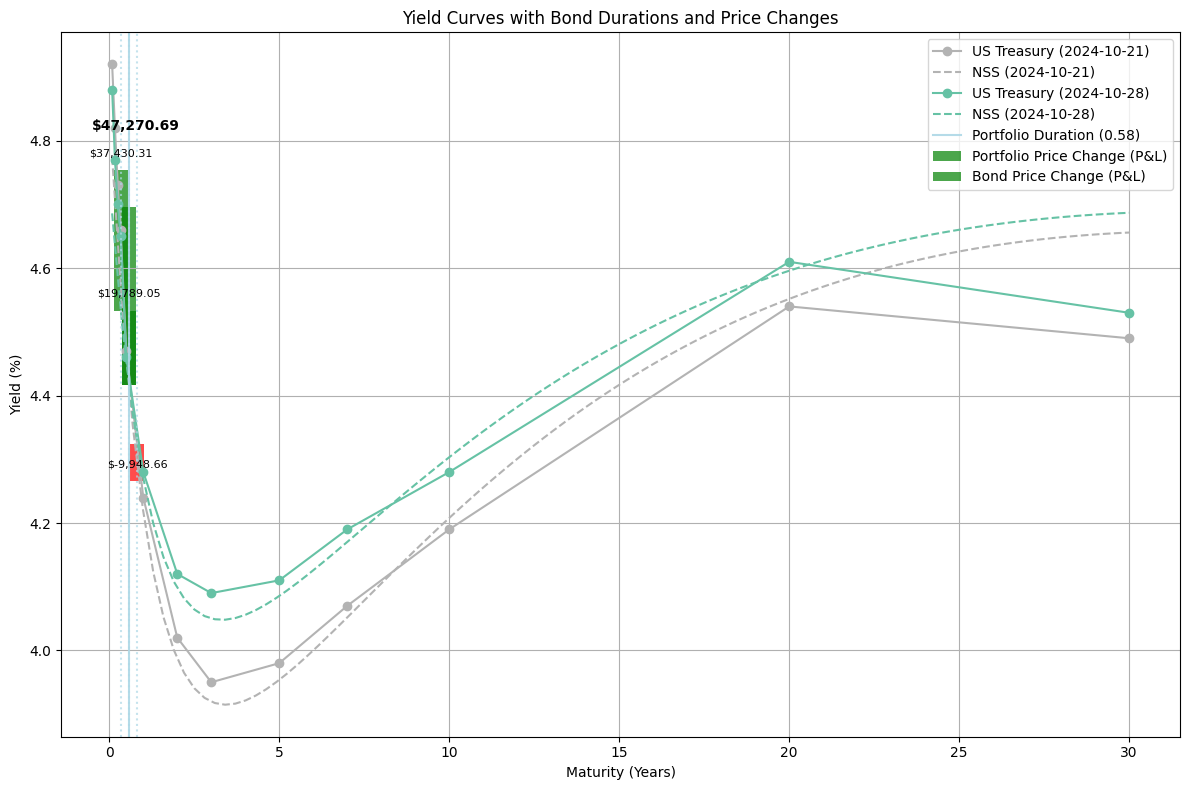

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $516,174,534.00    $516,221,804.69    $     47,270.69
Cash Balance:           $ 18,467,830.78    $216,073,729.60    $197,605,898.82
Total Value:            $516,174,534.00    $516,221,804.69    $     47,270.69
Return:                                 0.01%
Mark-to-Market:                         $47,270.69
Accrual Interest:                       $-256,944.44
Unrealized P&L:                         $-209,673.75
Realized P&L:                           $197,605,898.82
Strategy Gain/Cost:                     $197,605,898.82
Duration:                               0.58
DV01:                                   $17,373.60
Yield Curve Shift:                      4.54%
Yield Change at Duration:               0.38%
Yield Impact:                           $-6,622.54
Convexity Impact:                       $8.51
Predicted Price Change:                 $-6,6

In [604]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[10]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[9], "%B %d %Y")

# Process time step with bullet strategy
metrics, portfolio_october_28, staged_date = process_time_step(
    portfolio=portfolio_october_28,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
    rebalance_strategy=bullet_strategy,
    strategy_args={
        "target_duration": 0.0,
        "max_deviation": 1,
        "scale_factor": 2,
        "initial_date": "2024-08-14",
    },
)

### 2024 November 04 - Hedging using Swaps

In [614]:
portfolio_november_04 = copy.deepcopy(portfolio_october_28)
# portfolio_november_04.sell_all(current_date)

In [615]:
# Create and add Bond objects to the portfolio for each selected CUSIP
Bond.load_bond_data(("Fixed Income Portfolio 2024 - Copy.xlsx"))
for cusip in selected_cusips:
    bond = Bond.create_bond_from_cusip(cusip, current_date, prev_date, settlement_date=current_date)
    portfolio_november_04.add_bond(bond, current_date)
portfolio_november_04.allocate_investment(custom_allocation, 200_000_000, current_date)
portfolio_november_04.print_portfolio_info()

PORTFOLIO SUMMARY
Initial Investment: $500,000,000.00
Currently Invested: $500,000,000.00
Cash Balance: $16,073,729.60
Market Value: $500,148,075.09
Mark-to-Market: $200,046,170.69
Accrual Interest: $255,798.15
Unrealized P&L: $200,301,968.84
Realized P&L: $-483,926,270.40
Growth: 38.80%
Portfolio Yield: 3.10%
Portfolio Yield (Weighted): 2.59%
Macaulay Duration: 3.91
Modified Duration: 3.79
Modified Duration (Weighted): 4.16
Dollar Duration: $18,959,760.25
DV01: $189,597.60
Convexity: 0.67
Approximate DV01: $189,597.73
Approximate Convexity: 0.66
Number of Bonds: 14
Number of Swaps: 0
Total Duration: 3.79
Total DV01: $189,597.60
Total Market Value: $516,221,804.69


In [616]:
# Add the Swap to the Portfolio
swap = Swap(
    cusip="SLXC1B5M",  # Unique identifier for the swap
    notional=-200_000_000,
    fixed_rate=0.035199,  # Fixed rate of 2.5%
    floating_rate=0.0532,  # Initial floating rate of 2%
    curve_date="2023-10-07",
    valuation_date="2023-10-11",
    start_date="2023-08-31",
    maturity="2025-08-31",
    fixed_frequency=2,  # Semiannual
    floating_frequency=1, # Annual
    yield_curve=yield_curve,
    sofr_file="sofr.xlsx",
    fixed_leg_basis=0,  # 30/360 day convention
    floating_leg_basis=2,  # actual/360 day convention
    swap_type="Payer"
)

swap.load_forward_curve(file_path="Pensford Forward Curve - 11.22.2024.xlsx")

print(swap.get_info())

SWAP INFORMATION
CUSIP: SLXC1B5M
Notional: $-200,000,000.00
Start Date: 2023-08-31
Maturity Date: 2025-08-31
Position: Payer
----------------------------------------

FIXED LEG
----------------------------------------
Fixed Rate: 3.52%
Fixed Coupon Frequency: 2
Fixed Leg Basis: 30/360
Fixed Leg Principal: $13,539,503.79
Accrual Interest (Fixed): $801,755.00
Fixed Leg Value: $12,737,748.79
Fixed Duration: 1.08702
Fixed DV01: $-1,471.77443
Fixed Leg Cash Flows:
  2024-02-29: $3,500,345.00 at 3.52% with period 0.38 years
  2024-08-31: $3,539,455.00 at 3.52% with period 0.89 years
  2025-02-28: $3,480,790.00 at 3.52% with period 1.38 years
  2025-08-31: $3,559,010.00 at 3.52% with period 1.89 years

FLOATING LEG
----------------------------------------
Floating Rate (Latest): 4.89%
Floating Coupon Frequency: 1
Floating Leg Basis: Actual/360
Floating Leg Principal: $-18,503,395.75
Accrual Interest (Floating): $-1,211,777.78
Floating Leg Value: $-17,291,617.97
Floating Duration: 1.33303
Floa

In [617]:
portfolio_november_04.add_swap(swap, current_date)

# Print portfolio information after adding the swap
portfolio_november_04.print_portfolio_info()

PORTFOLIO SUMMARY
Initial Investment: $500,000,000.00
Currently Invested: $500,000,000.00
Cash Balance: $20,627,598.77
Market Value: $500,148,075.09
Mark-to-Market: $195,492,301.52
Accrual Interest: $-154,224.63
Unrealized P&L: $195,338,076.89
Realized P&L: $-479,372,401.23
Growth: 37.84%
Portfolio Yield: 3.10%
Portfolio Yield (Weighted): 2.59%
Macaulay Duration: 3.91
Modified Duration: 3.79
Modified Duration (Weighted): 4.16
Dollar Duration: $18,959,760.25
DV01: $189,597.60
Convexity: 0.67
Approximate DV01: $189,597.73
Approximate Convexity: 0.66
Number of Bonds: 14
Number of Swaps: 1
Total Duration: 1.37
Total DV01: $190,587.64
Total Market Value: $516,221,804.69


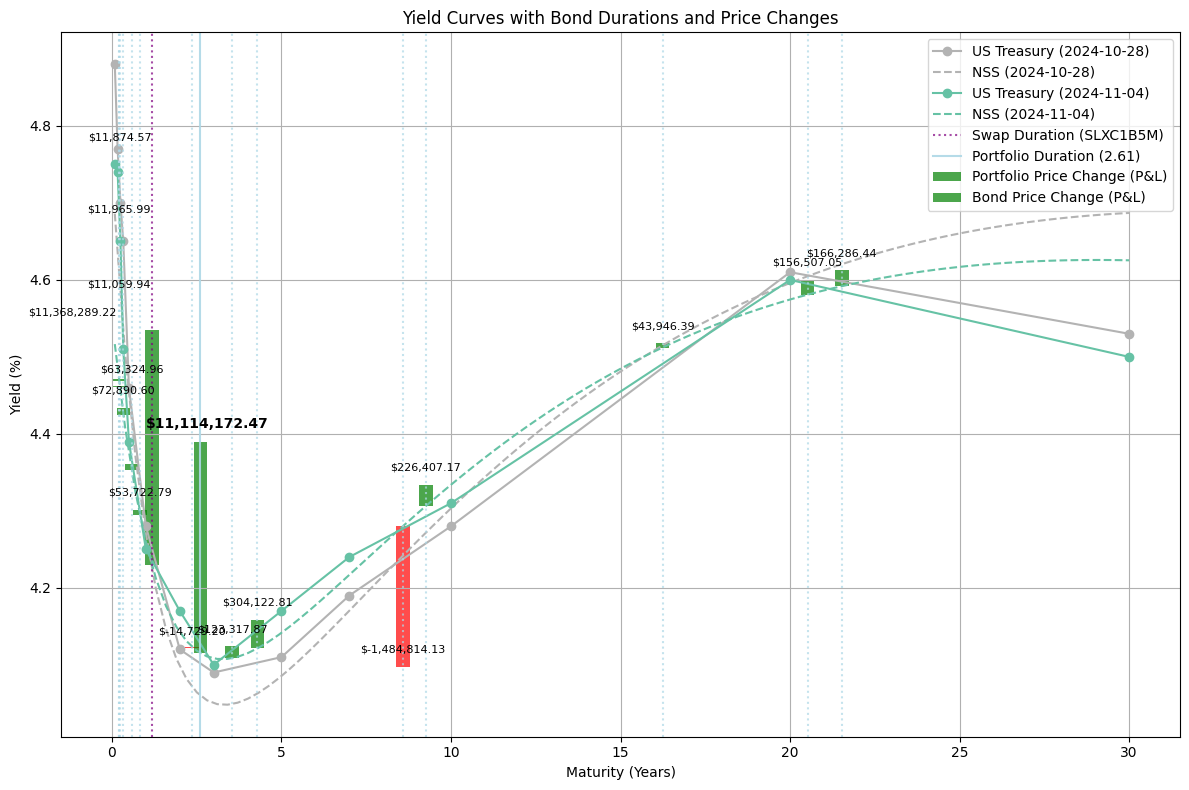

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $516,221,804.69    $527,335,977.16    $ 11,114,172.47
Cash Balance:           $ 20,627,598.77    $ 20,627,598.77    $          0.00
Total Value:            $516,221,804.69    $527,335,977.16    $ 11,114,172.47
Return:                                 2.15%
Mark-to-Market:                         $11,114,172.47
Accrual Interest:                       $-3,032,376.06
Unrealized P&L:                         $8,081,796.41
Realized P&L:                           $0.00
Strategy Gain/Cost:                     $0.00
Duration:                               2.61
DV01:                                   $189,211.09
Yield Curve Shift:                      -2.23%
Yield Change at Duration:               5.52%
Yield Impact:                           $-1,045,027.47
Convexity Impact:                       $508,094.94
Predicted Price Change:                 $-536,

In [618]:
# Parse the current sheet
sheet_name = excel_data.sheet_names[11]
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[10], "%B %d %Y")

# Process time step with bullet strategy
metrics, portfolio_november_04, staged_date = process_time_step(
    portfolio=portfolio_november_04,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
)

### 2024 November 18 - Hold Only

In [619]:
portfolio_november_18 = copy.deepcopy(portfolio_november_04)

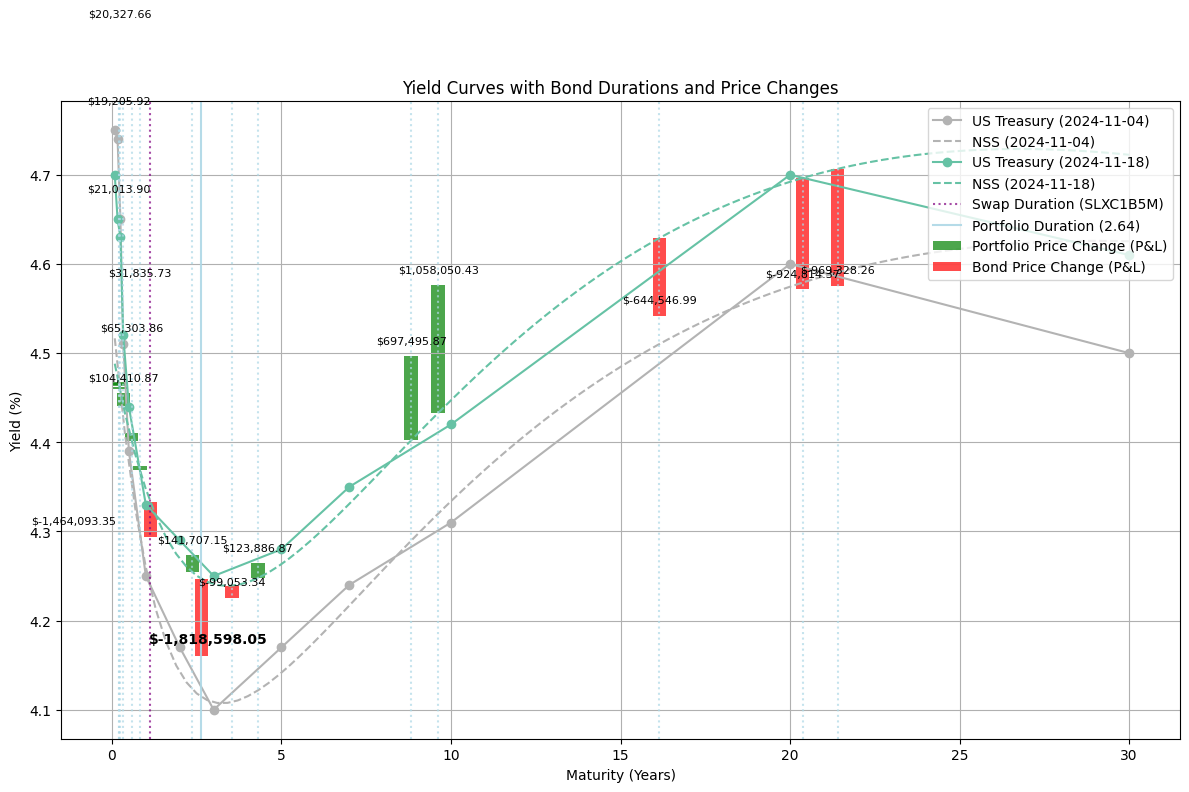

           Portfolio Performance Report           
Metric                         Previous        Current     Difference
Market Value:           $527,335,977.16    $525,517,379.11    $ -1,818,598.05
Cash Balance:           $ 20,627,598.77    $ 20,627,598.77    $          0.00
Total Value:            $527,335,977.16    $525,517,379.11    $ -1,818,598.05
Return:                                 -0.34%
Mark-to-Market:                         $-1,818,598.05
Accrual Interest:                       $1,258,946.30
Unrealized P&L:                         $-559,651.75
Realized P&L:                           $0.00
Strategy Gain/Cost:                     $0.00
Duration:                               2.64
DV01:                                   $188,581.18
Yield Curve Shift:                      6.08%
Yield Change at Duration:               13.25%
Yield Impact:                           $-2,498,498.61
Convexity Impact:                       $2,911,974.23
Predicted Price Change:                 $413,

In [620]:
sheet_name = excel_data.sheet_names[13]

# Parse the current sheet
sheet_data = excel_data.parse(sheet_name)
current_date = datetime.strptime(sheet_name, "%B %d %Y")
prev_date = datetime.strptime(excel_data.sheet_names[11], "%B %d %Y")

metrics, portfolio_november_18, staged_date = process_time_step(
    portfolio=portfolio_november_18,
    yield_curve=yield_curve,
    current_date=current_date,
    previous_date=prev_date,
    sheet_data=sheet_data,
    return_history=return_history,
)

### Return Summary

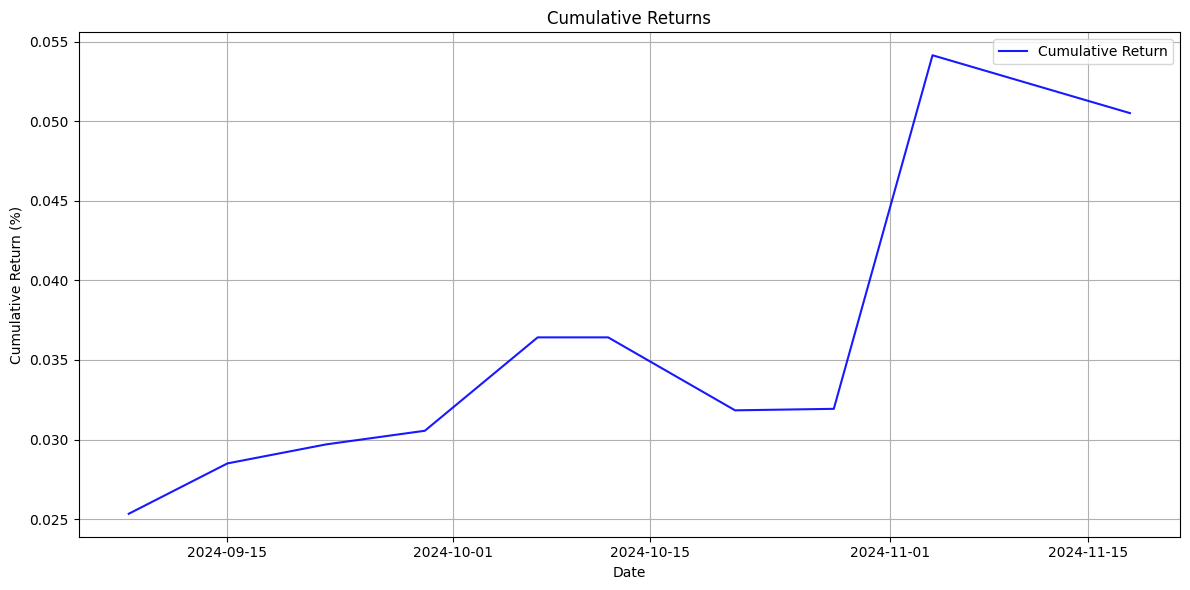

In [626]:
plot_return_history(return_history)